# Telecommunications Classification Project
***


## Project Objective
Find drivers for customer churn at Telco. Why are customers churning? Create a machine learning model that accuratley predicts churn in customers and document the key drivers.
***


## Executive Summary
- I found some the key factors that drive churn
    - Month to Month customers are more likely to churn
    - Customers with fiber internet are more likely to churn
    - Customers who pay by electronic check are more likley to churn
    - Customers who have two year contracts are less likely to churn 
    - Customers who recieve more from the company (ex. online security, tech support) are less likely to churn
- My Random forest 1 provides 79% accuracy and a 95% recall.
- Baseline was 73%
- Model will allow us to succesfully focus on the customers who are still with us, so we can focus on building their loyalty
- I recommend revisiting our fiber optic plan. As this plan brings in our highest paying customers we should include everything we can to please this customer. I would also reccomend cutting the cost of month to month plans by offering an inncentive to stay longer, stay 11 months and the 12 month is free to try and curb the monthly visitors leaving






***

## Import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from acquire import get_connection, new_telco_churn_data, get_telco_churn_data
from prepare import clean_telco_df, prep_telco, telco_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics

***

## Acquire

In [2]:
# this acquire function pulls the data using a SQL query, puts it into a usable dataframe and creates a csv file of the data. 
df = get_telco_churn_data()

In [3]:
# Let's take a look at the dataframe
df.head()

,payment_type_id,contract_type_id,internet_service_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,internet_service_type,contract_type,payment_type
0,2,1,3,0030-FNXPP,Female,0,No,No,3,Yes,...,No internet service,No internet service,No internet service,No,19.85,57.2,No,None,Month-to-month,Mailed check
1,2,1,3,0031-PVLZI,Female,0,Yes,Yes,4,Yes,...,No internet service,No internet service,No internet service,No,20.35,76.35,Yes,None,Month-to-month,Mailed check
2,1,1,3,0098-BOWSO,Male,0,No,No,27,Yes,...,No internet service,No internet service,No internet service,Yes,19.40,529.8,No,None,Month-to-month,Electronic check
3,1,1,3,0107-WESLM,Male,0,No,No,1,Yes,...,No internet service,No internet service,No internet service,Yes,19.85,19.85,Yes,None,Month-to-month,Electronic check
4,3,1,3,0114-RSRRW,Female,0,Yes,No,10,Yes,...,No internet service,No internet service,No internet service,Yes,19.95,187.75,No,None,Month-to-month,Bank transfer (automatic)


In [4]:
#The dataframe is going to need alot of encoding, also I dont like that the columns tech support
#streaming tv and streaming movies have three options. no internet service should be treated the same as 
# no. I also want to separte automatic payment from payment type

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   contract_type_id          7043 non-null   int64  
 2   internet_service_type_id  7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-null   object 
 14  tech_sup

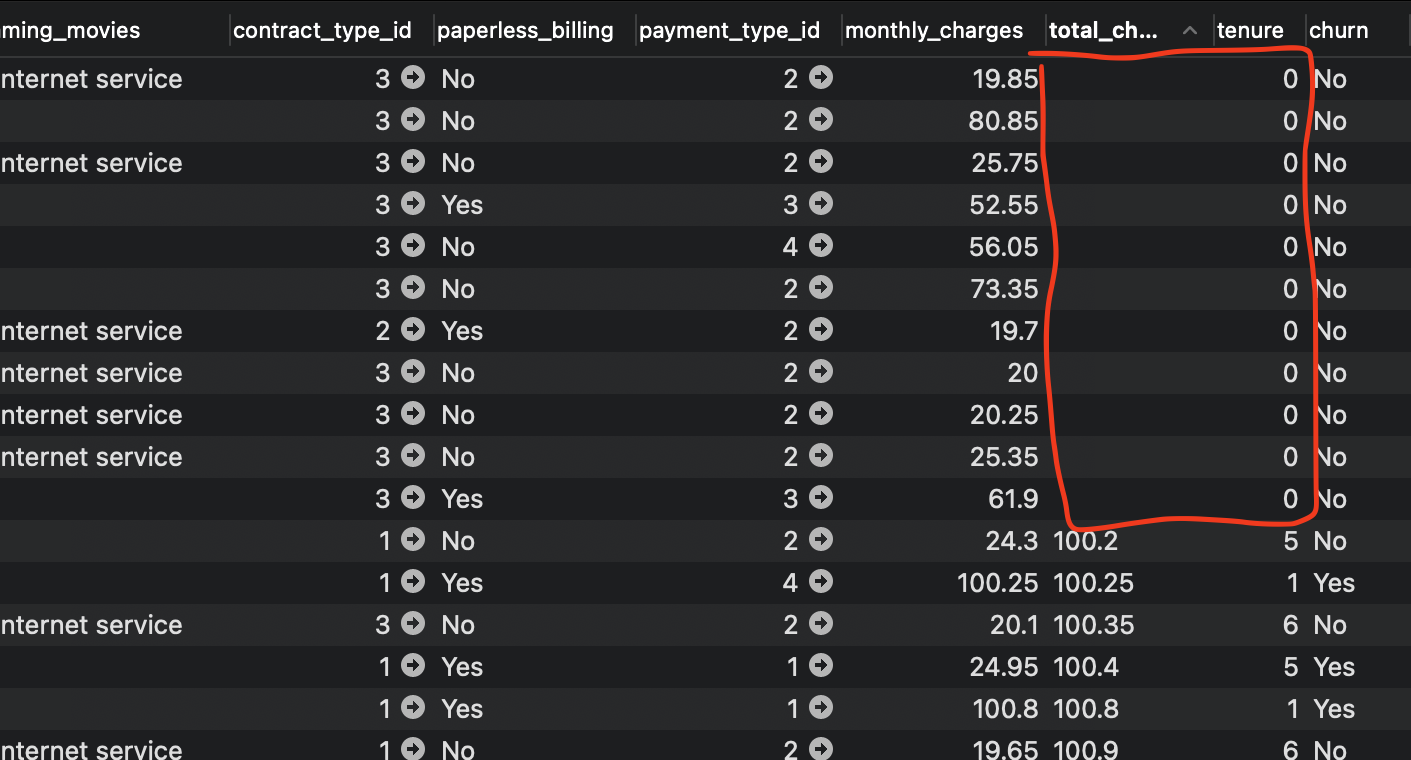

In [6]:
# Total charges is an object. I want it to be a float. Also there are 11 customers with no total
# charges, this is because this is there first month with the company. They have not been charged yet
# so moving foward their total charges will be zero.
from IPython.display import Image
Image(filename='tenure.png',width=800, height=400)

### Key takeaways
- I will need to encode almost every column
- Changes need to be made to total charges to fix the 11 missing values and make them a float
- I'm ready to create my prepare file to clean and split the data.
***

## Prepare


In [7]:
# The prep_telco function cleans the data, fixing total_charges as previously discussed and encoding every column
# I've also dropped all duplicate coulmns.I then split into train validate and split
# into train, validate, and test
train , validate , test = prep_telco(df)

In [8]:
train.shape, validate.shape, test.shape

((3943, 29), (1691, 29), (1409, 29))

***

## Explore

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3943 entries, 5707 to 6864
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   customer_id                 3943 non-null   object 
 1   senior_citizen              3943 non-null   int64  
 2   tenure                      3943 non-null   int64  
 3   monthly_charges             3943 non-null   float64
 4   total_charges               3943 non-null   float64
 5   is_male                     3943 non-null   uint8  
 6   has_partner                 3943 non-null   uint8  
 7   has_dependents              3943 non-null   uint8  
 8   has_phone_service           3943 non-null   uint8  
 9   has_multiple_lines          3943 non-null   uint8  
 10  has_online_security         3943 non-null   uint8  
 11  has_online_backup           3943 non-null   uint8  
 12  has_device_protection       3943 non-null   uint8  
 13  has_tech_support            39

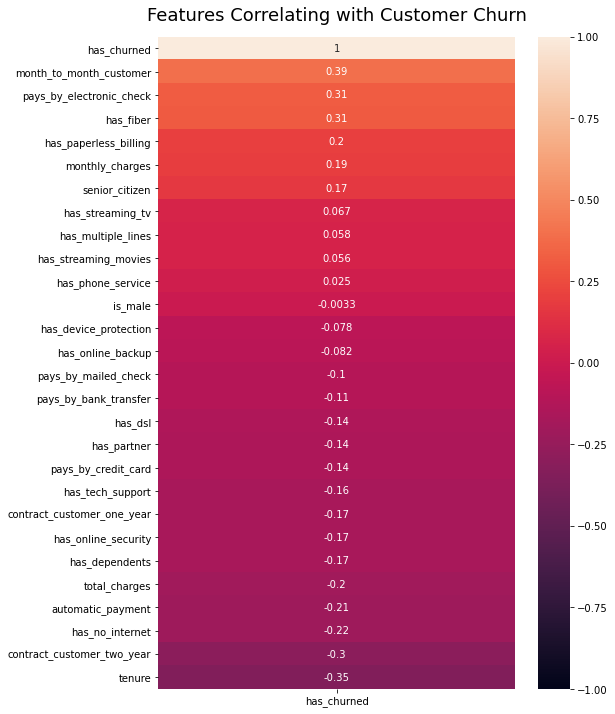

In [10]:
# Make a heatmap that shows correlation of churn and other variables
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(train.corr()[['has_churned']].sort_values(by='has_churned', ascending=False), vmin=-1, vmax=1, annot=True, cmap='rocket')
heatmap.set_title('Features Correlating with Customer Churn', fontdict={'fontsize':18}, pad=16);

Text(0, 0.5, 'Correlation')

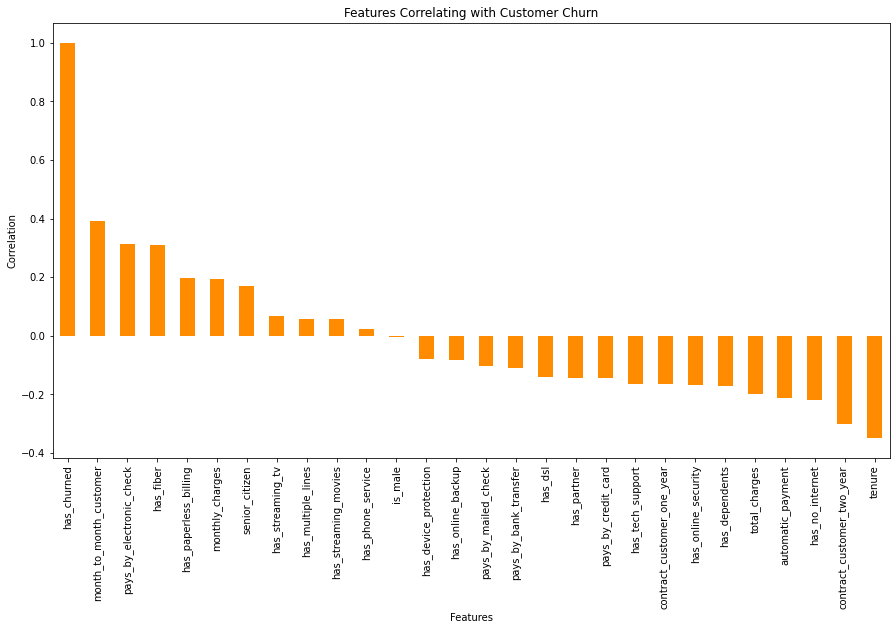

In [11]:
# Similar to graph above different angle 
plt.figure(figsize=(15,8))
train.corr()['has_churned'].sort_values(ascending = False).plot(kind='bar',color = "darkorange")
plt.title("Features Correlating with Customer Churn")
plt.xlabel("Features")
plt.ylabel("Correlation")

- closer to 1 means strong positive correlation
- closer to -1 means strong negative correlation
- Month to month customers are more likely to churn, which we know
- electonic checks and Fiberoptic customers are also a very high correlation
- it appears that people who have extra services become less likely to churn ex(tech support, online security, and device protection.) 

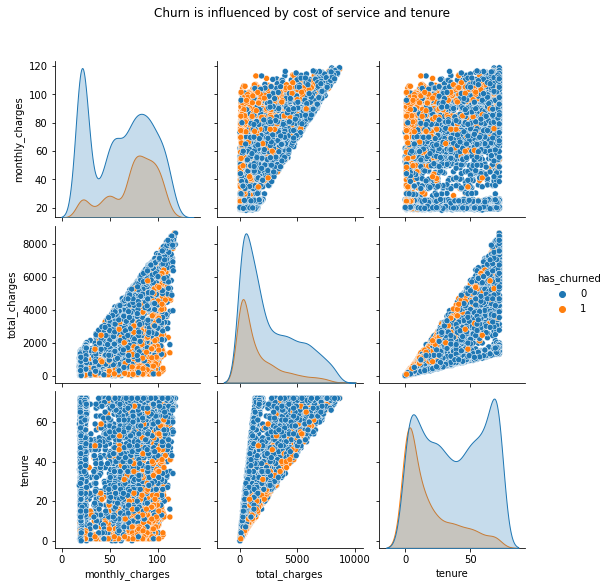

In [12]:
g = sns.pairplot(train, vars = ['monthly_charges','total_charges','tenure'], hue = 'has_churned')
g.fig.suptitle("Churn is influenced by cost of service and tenure", y=1.08)
plt.show()

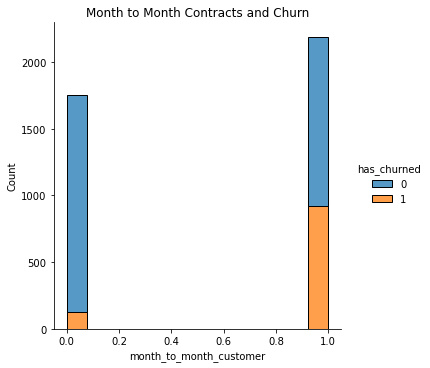

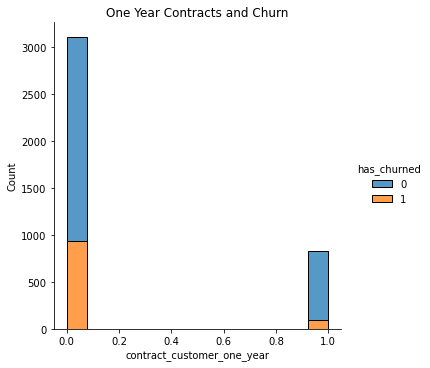

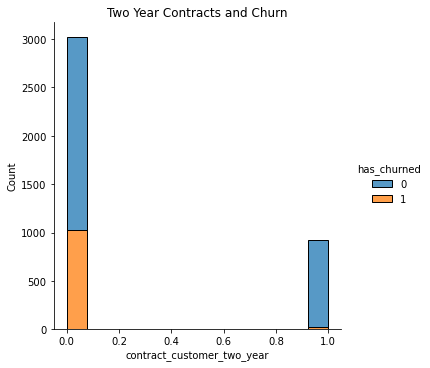

In [13]:
sns.displot(train, x='month_to_month_customer', hue = 'has_churned', multiple= 'stack')
plt.title('Month to Month Contracts and Churn')
plt.show()

sns.displot(train, x='contract_customer_one_year', hue = 'has_churned', multiple= 'stack')
plt.title('One Year Contracts and Churn')
plt.show()


sns.displot(train, x='contract_customer_two_year', hue = 'has_churned', multiple= 'stack')
plt.title('Two Year Contracts and Churn')
plt.show()



- as expected churn is influenced by cost
- the longer you are with the company the less likely you are to churn 
- contract types have a large role in churn 

# Lets make some hypothesis

In [14]:
# Set alpha to 5%
alpha = .05

###### Hypothesis 1
${H}_{0}$ Month to month customers and churn are independent

${H}_{a}$ Month to month customers and churn are not independent of each other 

###### Hypothesis 2
${H}_{0}$ Customers with 2 year contracts and churn are independent

${H}_{a}$ Customers with 2 year contracts customers and churn are not independent of each other 

###### Hypothesis 3
${H}_{0}$ Customers with fiber oprtic internet and churn are independent

${H}_{a}$ Customers with fiber optic internet  and churn are not independent of each other 

###### Hypothesis 4
${H}_{0}$ Customers with online security and churn are independent

${H}_{a}$ Customers with online security and churn are not independent of each other 

###### Hypothesis 5
${H}_{0}$ Customers who pay with electronic check and churn are independent

${H}_{a}$ Customers who pay with electronic check are not independent of each other 

In [15]:
# Creating a dataframe that holds all of my chi square results 
table=[]
for x in train[['month_to_month_customer','contract_customer_two_year','has_fiber', 'has_online_security', 'pays_by_electronic_check']]:
    cross = pd.crosstab(index = train['has_churned'], columns = train[x])
    chi, p, dof, expected = stats.chi2_contingency(cross)
    table.append(
        {
            'Column': x,
            'chi_score': chi,
            'p_score':  p
        }
    )
pd.DataFrame(table)

,Column,chi_score,p_score
0,month_to_month_customer,602.116916,5.799015e-133
1,contract_customer_two_year,351.813702,1.706802e-78
2,has_fiber,380.277798,1.082631e-84
3,has_online_security,110.365313,8.149875e-26
4,pays_by_electronic_check,383.891191,1.769290e-85


### Key take aways from these hypothesis.
- We can sucessfully reject the ${H}_{0}$ for every hypothesis because the p value is less than our alpha of .05
-  These are all potential drivers of churn 
- The chi square test also suggest that the strongest correlation is with month to month customers followed by customers who have fiber internet, customers who pay with electronic check customers with 2 year contracts, and online security 
***

###### Hypothesis 6
${H}_{0}$ Tenure and churn are independent

${H}_{a}$ Tenure and churn are not independent

In [16]:
# run an single tail Ttest to compare the means

table2=[]
t, p = stats.ttest_ind(train[train.has_churned==0].tenure, train[train.has_churned==1].tenure)
table2.append(
        {
            'Column': "Tenure",
            't_statistic': t,
            'p_value':  p
        }
    )
pd.DataFrame(table2)

,Column,t_statistic,p_value
0,Tenure,23.355177,4.227772e-113


 Key take aways:
- We can sucessfully reject the ${H}_{0}$  because the p value is less than our alpha of .05
- Tenure does appear to be a factor of churn

## Modeling

### Baseline

In [17]:
train['baseline'] = 0
baseline_accuracy = (train.baseline == train.has_churned).mean()
print(f'Baseline accuracy is {baseline_accuracy:.2%}')


Baseline accuracy is 73.47%


In [18]:
# lets split my data into the features I want to focus on.
x_col = ['month_to_month_customer','contract_customer_two_year','has_fiber', 'has_online_security', 'pays_by_electronic_check', 'tenure']
y_col = 'has_churned'

X_train, y_train = train[x_col], train[y_col]

X_validate, y_validate = validate[x_col], validate[y_col]

X_test, y_test = test[x_col], test[y_col]

### Decision tree Classifier

In [19]:
## Create a for loop that creates 20 decision tree models with increasingly larger depths.
metrics = []
tree_models = []
for i in range(2, 22):
    # Make the model
    tree = DecisionTreeClassifier(max_depth=i, random_state=123)

    # Fit the model (on train and only train)
    tree = tree.fit(X_train, y_train)
    y_predictions = tree.predict(X_train)
    y_pred = tree.predict(X_validate)
    # Use the model
    in_sample_accuracy = round(tree.score(X_train, y_train),3)
    
    out_of_sample_accuracy = round(tree.score(X_validate, y_validate),3)
    
    in_sample_recall = round(sklearn.metrics.recall_score(y_train, y_predictions, pos_label =0),3)
    
    out_of_sample_recall = round(sklearn.metrics.recall_score(y_validate, y_pred, pos_label =0),3)
    output = {
        "max_depth": i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy,
        "train_recall": in_sample_recall,
        "validate_recall": out_of_sample_recall
    }
    
    # This creates the df below
    metrics.append(output)
    # tree_models will store all of my tree models incase i want them later
    tree_models.append(tree)
    
tree_df = pd.DataFrame(metrics)
tree_df["accuracy_difference"] = tree_df.train_accuracy - tree_df.validate_accuracy
tree_df

,max_depth,train_accuracy,validate_accuracy,train_recall,validate_recall,accuracy_difference
0,2,0.761,0.753,0.808,0.807,0.008
1,3,0.796,0.782,0.933,0.920,0.014
2,4,0.800,0.783,0.918,0.904,0.017
3,5,0.800,0.784,0.936,0.921,0.016
4,6,0.806,0.786,0.886,0.878,0.020
5,7,0.808,0.786,0.886,0.878,0.022
6,8,0.811,0.779,0.912,0.888,0.032
7,9,0.816,0.768,0.897,0.859,0.048
8,10,0.820,0.768,0.908,0.867,0.052
9,11,0.824,0.765,0.904,0.861,0.059


### Key take aways:
- Definitely seeing overfitting with decision tree 
- I really like deciesion tree 3 with **80%** accuracy in train and **78.4%** in validate.
- Tree 3 also has a fantastic recall rate with **93%** in train and **92%** in validate
- Definetly out performs our baseline **73%**

In [20]:
## Create a for loop that creates 20 Random Forrest models with increasingly larger depths.
metrics2 = []
forest_models = []
for i in range(2, 22):
    # Make the model
    forest = RandomForestClassifier(max_depth=i, random_state=123)

    # Fit the model (on train and only train)
    forest = forest.fit(X_train, y_train)
    
    y_predictions = forest.predict(X_train)
    y_pred = forest.predict(X_validate)
    
    # Use the model
    in_sample_accuracy = round(forest.score(X_train, y_train),3)
    
    out_of_sample_accuracy = round(forest.score(X_validate, y_validate),3)
    
    in_sample_recall = round(sklearn.metrics.recall_score(y_train, y_predictions, pos_label =0),3)
    
    out_of_sample_recall = round(sklearn.metrics.recall_score(y_validate, y_pred, pos_label =0),3)
    
    output = {
        "max_depth": i,
        "train_accuracy": in_sample_accuracy,
        "validate_accuracy": out_of_sample_accuracy,
        "train_recall": in_sample_recall,
        "validate_recall": out_of_sample_recall
    }
    
    # This creates the df below
    metrics2.append(output)
    # tree_models will store all of my tree models incase i want them later
    forest_models.append(forest)
    
    
    
forest_df = pd.DataFrame(metrics2)
forest_df["accuracy_difference"] = forest_df.train_accuracy - forest_df.validate_accuracy
forest_df

,max_depth,train_accuracy,validate_accuracy,train_recall,validate_recall,accuracy_difference
0,2,0.778,0.772,0.960,0.951,0.006
1,3,0.790,0.779,0.952,0.940,0.011
2,4,0.799,0.784,0.928,0.915,0.015
3,5,0.803,0.788,0.912,0.906,0.015
4,6,0.809,0.789,0.919,0.908,0.020
5,7,0.812,0.786,0.912,0.901,0.026
6,8,0.816,0.784,0.906,0.886,0.032
7,9,0.824,0.775,0.912,0.873,0.049
8,10,0.829,0.767,0.915,0.866,0.062
9,11,0.831,0.765,0.914,0.863,0.066


### Key Take aways
- Forest 1 looks like a strong performer
- with **79%** accuracy in train and **77.9%** in validate
- Forrest 1 also has a fantastic recall rate with **95.2%** in train and **94%** in validate

In [21]:
metrics = []

# loop through different values of k
for k in range(1, 21):
            
    # define the thing
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # fit the thing (remmeber only fit on training data)
    knn.fit(X_train, y_train)
    
    y_predictions = knn.predict(X_train)
    y_pred = knn.predict(X_validate)
    # use the thing (calculate accuracy)
    train_accuracy = round(knn.score(X_train, y_train),3)
    validate_accuracy = round(knn.score(X_validate, y_validate),3)
    train_recall = round(sklearn.metrics.recall_score(y_train, y_predictions, pos_label =0),3)
    validate_recall = round(sklearn.metrics.recall_score(y_validate, y_pred, pos_label =0),3)
    output = {
        "k": k,
        "train_accuracy": train_accuracy,
        "validate_accuracy": validate_accuracy,
        'train_recall':train_recall,
        "validate_recall":validate_recall
    }
    
    metrics.append(output)

# make a dataframe

results = pd.DataFrame(metrics)
results["accuracy_difference"] = results.train_accuracy - results.validate_accuracy
results

,k,train_accuracy,validate_accuracy,train_recall,validate_recall,accuracy_difference
0,1,0.793,0.738,0.884,0.848,0.055
1,2,0.786,0.769,0.954,0.936,0.017
2,3,0.803,0.771,0.901,0.877,0.032
3,4,0.797,0.775,0.944,0.925,0.022
4,5,0.805,0.765,0.916,0.890,0.040
5,6,0.796,0.771,0.944,0.924,0.025
6,7,0.808,0.776,0.914,0.893,0.032
7,8,0.803,0.778,0.943,0.919,0.025
8,9,0.804,0.781,0.893,0.880,0.023
9,10,0.803,0.778,0.938,0.920,0.025


### Key take aways 
- KNN 1 looks like a strong performer
- with **78.6%** accuracy in train and **76.9%** in validate
- Forrest 1 also has a fantastic recall rate with **95.4%** in train and **93.6%** in validate

## Test
- I will be using my 2nd forest model as it has the highest accuracy and recall rate

In [22]:
forest = RandomForestClassifier(max_depth=3, random_state=123)
forest = forest.fit(X_train, y_train)
actual_test = y_test
predicted_test = forest.predict(X_test)
print(classification_report(actual_test, predicted_test))

              precision    recall  f1-score   support

           0       0.80      0.95      0.87      1035
           1       0.72      0.33      0.46       374

    accuracy                           0.79      1409
   macro avg       0.76      0.64      0.66      1409
weighted avg       0.78      0.79      0.76      1409



In [23]:

#let's see the training, validate, and test score. All better than the baseline of 73.4%
print(f'training score: {forest.score(X_train, y_train):.2%}')
print(f'validate score: {forest.score(X_validate, y_validate):.2%}')
print(f'test score: {forest.score(X_test, y_test):.2%}')

training score: 79.00%
validate score: 77.94%
test score: 78.85%


### Key Findings:
- random forest 1 provides 79% accuracy and a 95% recall. 
- out performs baseline by over 5 % but more importantly that recall
***

## Deliverable

In [24]:
#Verifying customer id is there, in an earlier draft I had dropped customer id 
test.head()

,customer_id,senior_citizen,tenure,monthly_charges,total_charges,is_male,has_partner,has_dependents,has_phone_service,has_multiple_lines,...,has_dsl,has_fiber,has_no_internet,month_to_month_customer,contract_customer_one_year,contract_customer_two_year,pays_by_bank_transfer,pays_by_credit_card,pays_by_electronic_check,pays_by_mailed_check
3960,2592-HODOV,0,13,19.30,259.65,1,0,0,1,0,...,0,0,1,0,1,0,0,1,0,0
2131,7426-GSWPO,1,64,103.50,6548.65,1,0,0,1,1,...,0,1,0,1,0,0,1,0,0,0
5313,9378-FXTIZ,0,54,70.15,3715.65,0,1,0,1,1,...,1,0,0,0,1,0,0,1,0,0
4295,1017-FBQMM,0,62,106.05,6703.50,0,1,1,1,1,...,0,1,0,0,1,0,0,1,0,0
772,1193-RTSLK,0,38,83.90,3233.60,0,0,0,1,0,...,0,1,0,1,0,0,0,1,0,0


In [25]:
# creating probability columns of churn based off my model
proba_test = forest.predict_proba(X_test)

In [26]:
# creating a dataframe for them, and rounded them off. 
proba_df = pd.DataFrame(proba_test, columns=forest.classes_.tolist()).round(2)
proba_df.head()

,0,1
0,0.88,0.12
1,0.70,0.30
2,0.91,0.09
3,0.82,0.18
4,0.69,0.31


In [27]:
#reset the index of out test dataframe 
fresh_test = test.reset_index(drop=True)
fresh_test.head()

,customer_id,senior_citizen,tenure,monthly_charges,total_charges,is_male,has_partner,has_dependents,has_phone_service,has_multiple_lines,...,has_dsl,has_fiber,has_no_internet,month_to_month_customer,contract_customer_one_year,contract_customer_two_year,pays_by_bank_transfer,pays_by_credit_card,pays_by_electronic_check,pays_by_mailed_check
0,2592-HODOV,0,13,19.30,259.65,1,0,0,1,0,...,0,0,1,0,1,0,0,1,0,0
1,7426-GSWPO,1,64,103.50,6548.65,1,0,0,1,1,...,0,1,0,1,0,0,1,0,0,0
2,9378-FXTIZ,0,54,70.15,3715.65,0,1,0,1,1,...,1,0,0,0,1,0,0,1,0,0
3,1017-FBQMM,0,62,106.05,6703.50,0,1,1,1,1,...,0,1,0,0,1,0,0,1,0,0
4,1193-RTSLK,0,38,83.90,3233.60,0,0,0,1,0,...,0,1,0,1,0,0,0,1,0,0


In [28]:
# concating my probability to the test df.
test_proba_df = pd.concat([fresh_test, proba_df], axis=1)
test_proba_df.head()

,customer_id,senior_citizen,tenure,monthly_charges,total_charges,is_male,has_partner,has_dependents,has_phone_service,has_multiple_lines,...,has_no_internet,month_to_month_customer,contract_customer_one_year,contract_customer_two_year,pays_by_bank_transfer,pays_by_credit_card,pays_by_electronic_check,pays_by_mailed_check,0,1
0,2592-HODOV,0,13,19.30,259.65,1,0,0,1,0,...,1,0,1,0,0,1,0,0,0.88,0.12
1,7426-GSWPO,1,64,103.50,6548.65,1,0,0,1,1,...,0,1,0,0,1,0,0,0,0.70,0.30
2,9378-FXTIZ,0,54,70.15,3715.65,0,1,0,1,1,...,0,0,1,0,0,1,0,0,0.91,0.09
3,1017-FBQMM,0,62,106.05,6703.50,0,1,1,1,1,...,0,0,1,0,0,1,0,0,0.82,0.18
4,1193-RTSLK,0,38,83.90,3233.60,0,0,0,1,0,...,0,1,0,0,0,1,0,0,0.69,0.31


In [29]:
# Creating a predicted column using predicted test variable from cell 22
test_proba_df['predicted'] =predicted_test 
test_proba_df

,customer_id,senior_citizen,tenure,monthly_charges,total_charges,is_male,has_partner,has_dependents,has_phone_service,has_multiple_lines,...,month_to_month_customer,contract_customer_one_year,contract_customer_two_year,pays_by_bank_transfer,pays_by_credit_card,pays_by_electronic_check,pays_by_mailed_check,0,1,predicted
0,2592-HODOV,0,13,19.30,259.65,1,0,0,1,0,...,0,1,0,0,1,0,0,0.88,0.12,0
1,7426-GSWPO,1,64,103.50,6548.65,1,0,0,1,1,...,1,0,0,1,0,0,0,0.70,0.30,0
2,9378-FXTIZ,0,54,70.15,3715.65,0,1,0,1,1,...,0,1,0,0,1,0,0,0.91,0.09,0
3,1017-FBQMM,0,62,106.05,6703.50,0,1,1,1,1,...,0,1,0,0,1,0,0,0.82,0.18,0
4,1193-RTSLK,0,38,83.90,3233.60,0,0,0,1,0,...,1,0,0,0,1,0,0,0.69,0.31,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1404,1731-TVIUK,0,4,93.50,362.20,0,0,0,1,1,...,1,0,0,0,0,1,0,0.39,0.61,1
1405,4628-WQCQQ,0,35,85.15,3030.60,1,0,1,1,0,...,0,1,0,0,0,1,0,0.74,0.26,0
1406,5887-IKKYO,0,58,94.35,5563.65,1,1,1,1,1,...,0,0,1,1,0,0,0,0.91,0.09,0
1407,4931-TRZWN,0,13,71.95,923.85,0,0,0,1,0,...,1,0,0,0,0,1,0,0.66,0.34,0


In [35]:
# created a new clean df with customer id, the probability that the customer will churn and the prediction of my model
predictions = test_proba_df[['customer_id', 0,1, 'predicted']]
predictions.head()

,customer_id,0,1,predicted
0,2592-HODOV,0.88,0.12,0
1,7426-GSWPO,0.70,0.30,0
2,9378-FXTIZ,0.91,0.09,0
3,1017-FBQMM,0.82,0.18,0
4,1193-RTSLK,0.69,0.31,0


In [31]:
#to a csv it goes
predictions.to_csv('predictions.csv')

## Conclusion


- I found some the key factors that drive churn
    - Month to Month customers are more likely to churn
    - Customers with fiber internet are more likely to churn
    - Customers who pay by electronic check are more likley to churn
    - Customers who have two year contracts are less likely to churn 
    - Customers who recieve more from the company (ex. online security, tech support) are less likely to churn
- My Random forest 1 provides 79% accuracy and a 95% recall.
- Baseline was 73%

### Recommendation
- Model will allow us to succesfully focus on the customers who are still with us, so we can focus on building their loyalty
- I recommend revisiting our fiber optic plan. As this plan brings in our highest paying customers we should include everything we can to please this customer. I would also reccomend cutting the cost of month to month plans by offering an inncentive to stay longer, stay 11 months and the 12 month is free to try and curb the monthly visitors leaving

